### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

### Import the Dataset.

In [2]:
df = pd.read_csv('/kaggle/input/thyroid-cancer-risk-prediction-dataset/thyroid_cancer_risk_data.csv')

### Adjust Display Settings for Better Visualization

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase display width
pd.set_option('display.expand_frame_repr', False)  # Prevent column wrapping

### Explore Dataset: View Summary and Basic Statistics

In [4]:
print("===================================# DATA INSPECTION =================================== \n")
print("---------- # FIRST 5 ROWS # -----------\n", df.head())
print("---------- # LAST 5 ROWS # -----------\n", df.tail())
print("---------- # DATAFRAME SUMMARY # -----------\n", df.info())
print("---------- # STATISTICS OF NUMERICAL COLUMNS # -----------\n", df.describe().T)
print("---------- # DATA SHAPE (ROWS, COLUMNS) # -----------\n", df.shape)
print("---------- # COLUMN NAMES # -----------\n", df.columns)
print("---------- # DATA TYPES OF COLUMNS # -----------\n", df.dtypes)

# #### Check for Missing Values in Each Column
print("---------- # MISSING VALUES PER COLUMN # -----------\n", df.isnull().sum())

===================================# DATA INSPECTION =================================== 

---------- # FIRST 5 ROWS # -----------
    Patient_ID  Age  Gender  Country  Ethnicity Family_History Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  TSH_Level  T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk Diagnosis
0           1   66    Male   Russia  Caucasian             No                Yes                No      No      No       No       9.37      1.67      6.16         1.08                 Low    Benign
1           2   29    Male  Germany   Hispanic             No                Yes                No      No      No       No       1.83      1.73     10.54         4.05                 Low    Benign
2           3   86    Male  Nigeria  Caucasian             No                 No                No      No      No       No       6.26      2.59     10.57         4.61                 Low    Benign
3           4   75  Female    India      Asian             No               

### Visualize Distribution of Selected Categorical Features

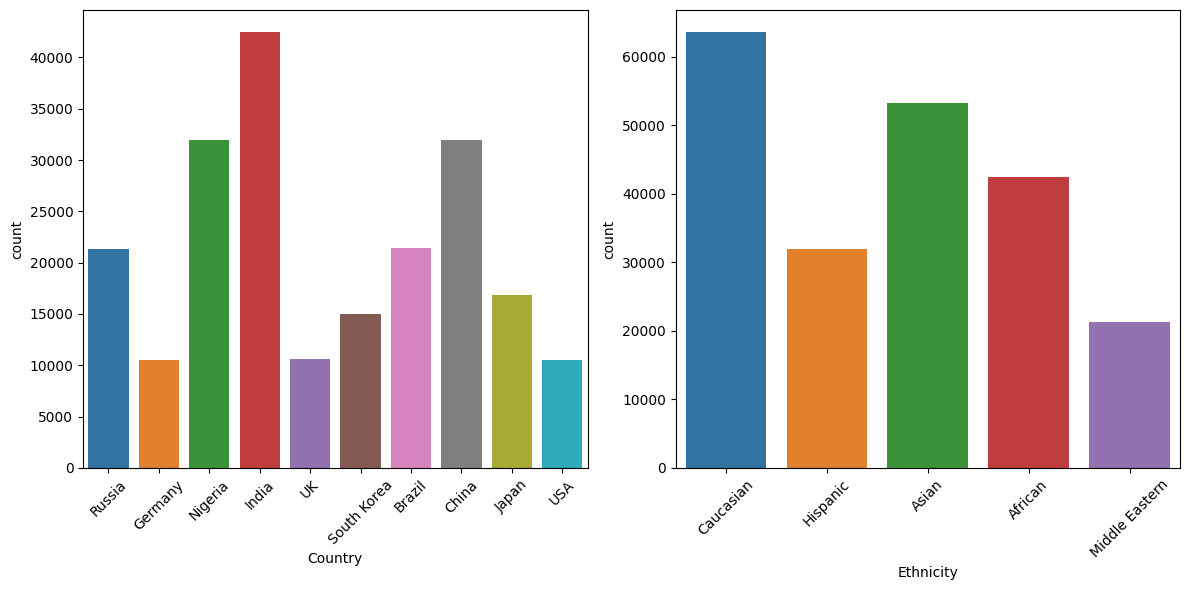

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
sns.countplot(x=df.iloc[:, 3])
plt.xticks(rotation=45)  # Rotate labels for readability

plt.subplot(122)
sns.countplot(x=df.iloc[:, 4])
plt.xticks(rotation=45) 
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### Check Unique Values for Country and Ethnicity

In [6]:
### Check Unique Values for Country and Ethnicity
df["Country"].value_counts()
df["Ethnicity"].value_counts()

Ethnicity
Caucasian         63669
Asian             53261
African           42414
Hispanic          32012
Middle Eastern    21335
Name: count, dtype: int64

### Perform Chi-Square Test to Check Statistical Significance of Categorical Features


In [7]:
country_ct = pd.crosstab(df["Country"], df["Thyroid_Cancer_Risk"])
ethnicity_ct = pd.crosstab(df["Ethnicity"], df["Thyroid_Cancer_Risk"])

chi2_country, p_country, _, _ = chi2_contingency(country_ct)
chi2_ethnicity, p_ethnicity, _, _ = chi2_contingency(ethnicity_ct)

print(f"Country p-value: {p_country}")
print(f"Ethnicity p-value: {p_ethnicity}")


Country p-value: 0.0
Ethnicity p-value: 0.0


Since p-values are < 0.05, Country and Ethnicity are statistically significant and must be retained.


### One-Hot Encoding for Categorical Features (Avoiding Multicollinearity)


In [8]:
encoder = OneHotEncoder(drop="first", sparse_output=False)  # Drop first to avoid redundancy
encoded = encoder.fit_transform(df[["Country", "Ethnicity"]])
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())



### Merge Encoded Features and Drop Original Columns


In [9]:
df = df.drop(["Country", "Ethnicity"], axis=1)
df = pd.concat([df, df_encoded], axis=1)

### Encode Binary Columns (Yes/No) as 1/0


In [10]:
binary_columns = [3, 4, 5, 6, 7, 8]  # Columns containing Yes/No values
df.iloc[:, binary_columns] = df.iloc[:, binary_columns].apply(lambda x: x.str.strip().str.lower())  # Normalize text
df.iloc[:, binary_columns] = df.iloc[:, binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))

### Encode Gender Column (Male = 1, Female = 0), Encode Ordinal Variable "Thyroid_Cancer_Risk" (Low < Medium < High)



In [11]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})


risk_mapping = {"Low": 0, "Medium": 1, "High": 2}  # Define order
df["Thyroid_Cancer_Risk"] = df["Thyroid_Cancer_Risk"].map(risk_mapping)  # Apply encoding

### Move "Diagnosis" Column to the Last Position


In [12]:
col = df.pop("Diagnosis")  # Remove the column
df["Diagnosis"] = col  # Add it back at the last position

### Split Dataset into Features (X) and Target Variable (y)


In [13]:
X = df.iloc[:, 1:-1]  # Select all columns except first and last as features
y = df.iloc[:, -1]  # Target variable

### Split into Training and Testing Sets (80% Train, 20% Test)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Encode Target Variable Using LabelEncoder


In [15]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_train = le.fit_transform(y_train)

### Check Variance of Features


In [16]:
columns = X_train.columns  # Extract column names
X_train.var(axis=0)  # Compute variance

Age                         467.275705
Gender                        0.240161
Family_History                0.209788
Radiation_Exposure            0.127625
Iodine_Deficiency             0.186942
Smoking                        0.15948
Obesity                       0.210328
Diabetes                      0.159961
TSH_Level                     8.185672
T3_Level                      0.751245
T4_Level                      4.682969
Nodule_Size                   2.086273
Thyroid_Cancer_Risk            0.53028
Country_China                 0.127814
Country_Germany               0.047158
Country_India                 0.159738
Country_Japan                 0.073353
Country_Nigeria                0.12739
Country_Russia                0.090352
Country_South Korea           0.065355
Country_UK                    0.047412
Country_USA                   0.047143
Ethnicity_Asian               0.187554
Ethnicity_Caucasian           0.209642
Ethnicity_Hispanic            0.128229
Ethnicity_Middle Eastern 

### Normalize Numerical Features Using Min-Max Scaling


In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use same scaler to transform test data

### Plot Feature Variance Distribution

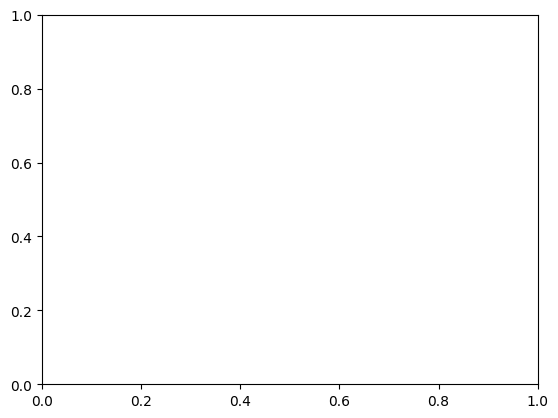

In [18]:
fig, ax = plt.subplots()
X_train_df = pd.DataFrame(X_train, columns=columns)  # Convert back to DataFrame

### Select subset of features for visualization


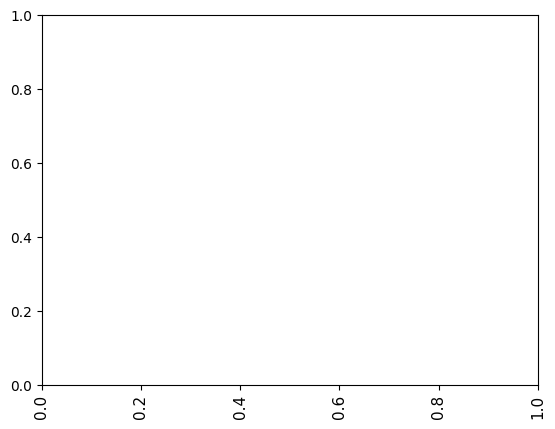

In [19]:
x = columns[8:12]
y = X_train_df.iloc[:, 8:12].var(axis=0)

ax.bar(x, y, width=0.9, align='edge')
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)
plt.xticks(rotation=90, fontsize=11)  # Rotate X-axis labels for clarity

fig.autofmt_xdate()
plt.show()

### Heatmap

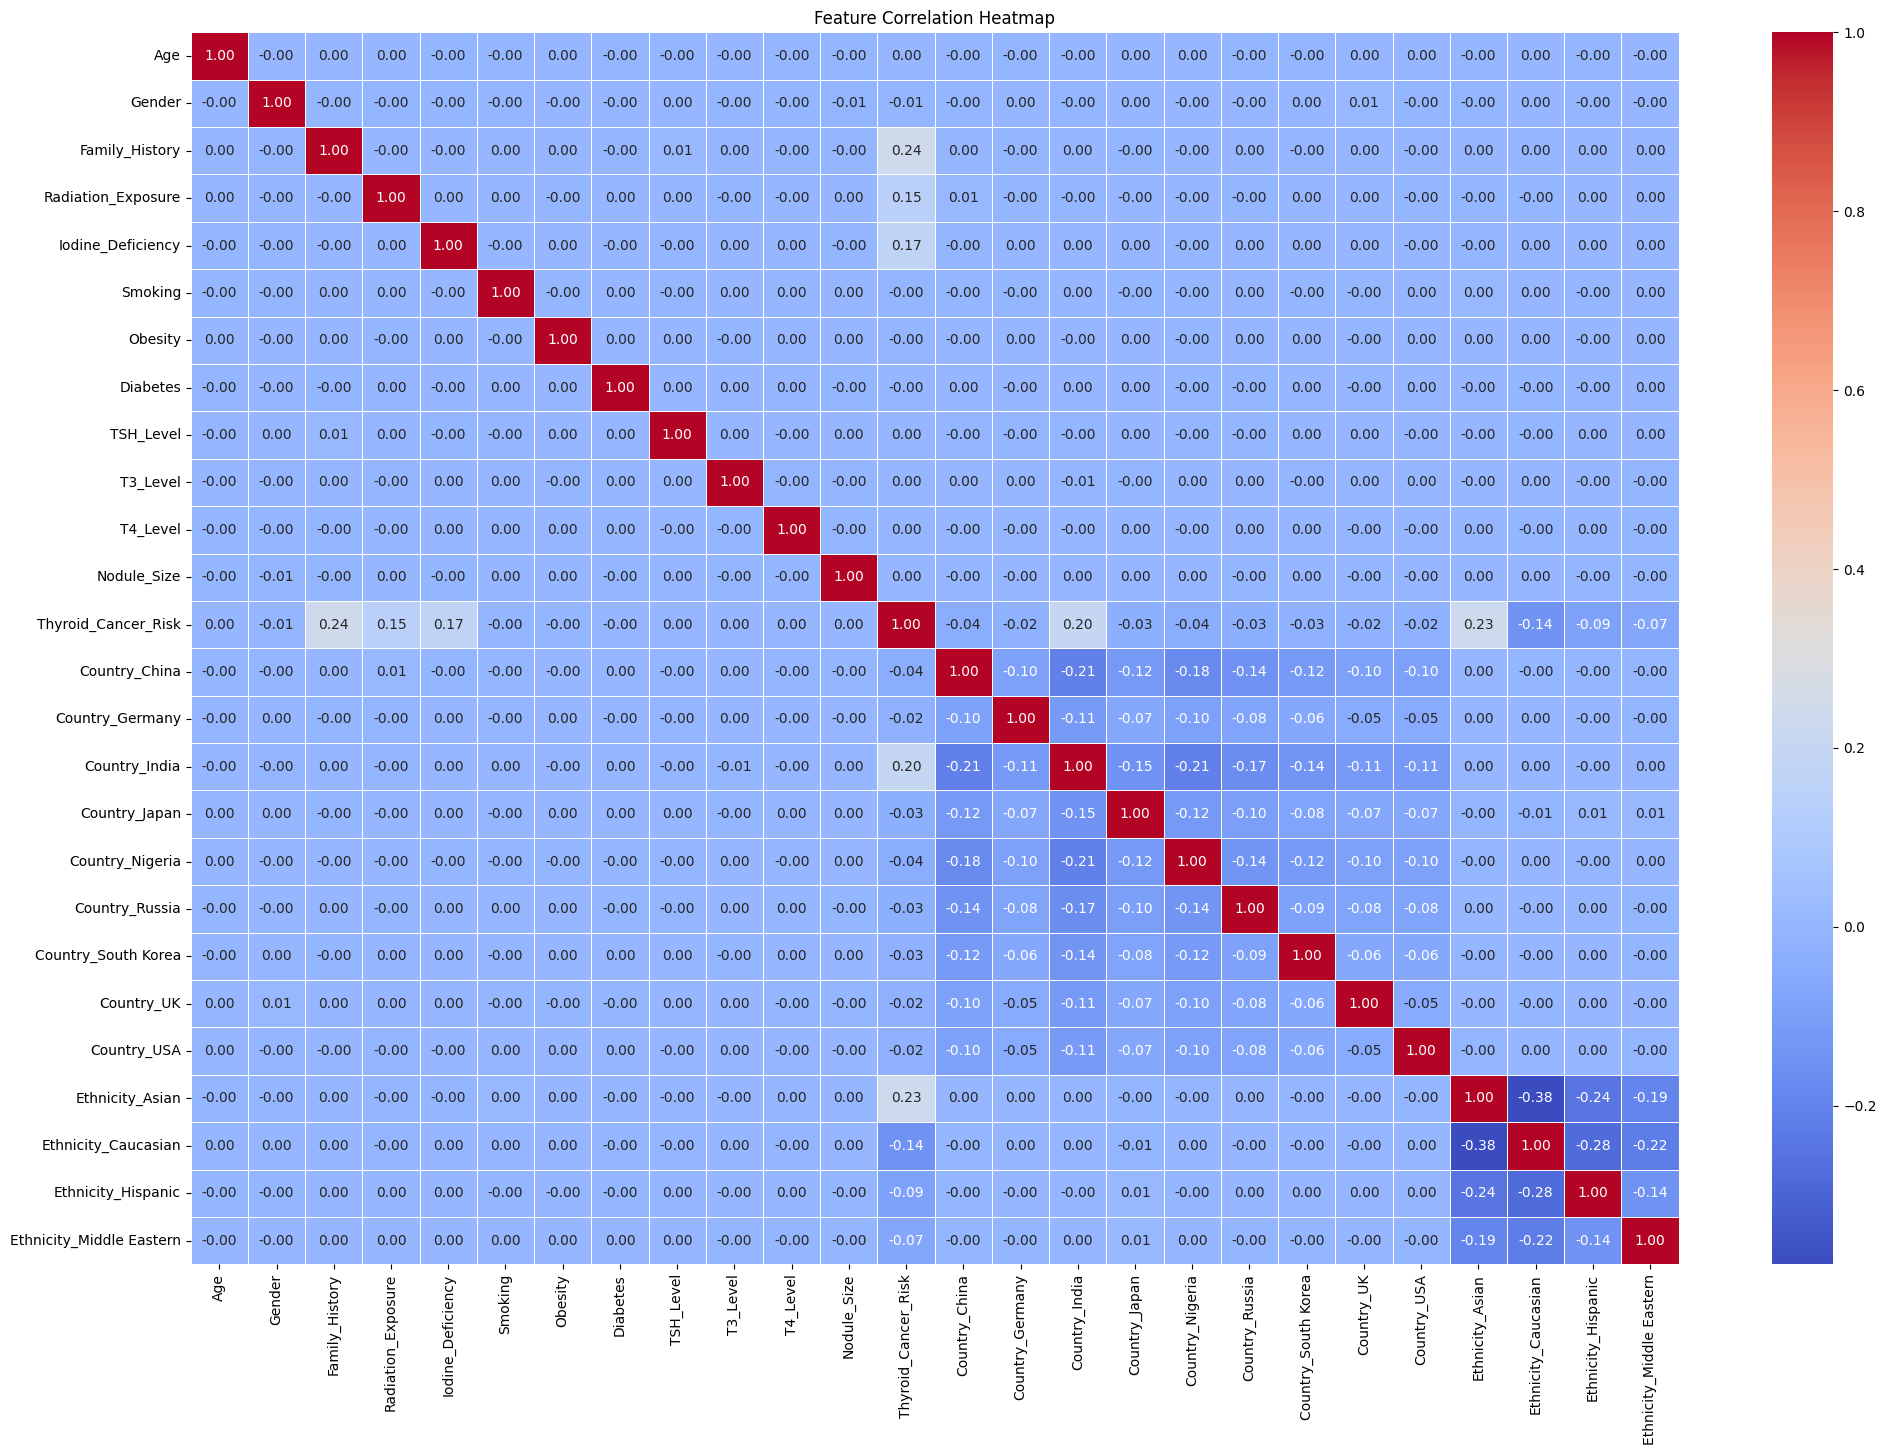

In [20]:
### Check Feature Correlation Using Heatmap

corr_matrix = X_train_df.corr()  # Compute correlation matrix

### Plot heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


 No features are strongly correlated. No need to drop any column.

### Train AdaBoost Classifier


In [21]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Model Evaluation: Accuracy Score

In [22]:
accuracy = round(accuracy_score(y_test, pred), 3)
print(f"Model Accuracy: {accuracy * 100:.1f}%")  # Convert to percentage

Model Accuracy: 83.0%


### Compare Predictions with Actual Labels


In [23]:
comparison_df = pd.DataFrame(
    np.concatenate((pred.reshape(len(pred), 1), y_test.reshape(len(pred), 1)), axis=1),
    columns=['Predicted', 'Actual']
)
print(comparison_df.head(10))  # Display first 10 comparisons

   Predicted  Actual
0          0       0
1          0       0
2          1       0
3          0       0
4          1       1
5          0       0
6          0       1
7          1       1
8          0       0
9          1       0


### Print Classification Report for Performance Evaluation


In [24]:
print("\nClassification Report:\n", classification_report(y_test, pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     32804
           1       0.70      0.46      0.55      9735

    accuracy                           0.83     42539
   macro avg       0.77      0.70      0.72     42539
weighted avg       0.82      0.83      0.82     42539

